## Anomaly Detection in Time Series Sensor Data

### Elliptic Envelope

- Creates an imaginary elliptical area around a given dataset. Values that fall inside the envelope are considered normal data and anything outside the envelope is returned as outliers.

- we need to specify the contamination hyperparameter. It represents the proportion of outliers in the dataset. The values of this hyperparameter are ranging from 0 to 0.5 (default is 0.1)

CRISP - DM methodology:

- Business understanding
- Data understanding
- Data transformation
- Modeling
- Evaluation
- Deployment

### Business understanding

- The data are from sensors of water pump in one small town.

- There are 53 sensors intalled on that pump and they are actually KPIs for monitoring behaviour of the pump.

- The task is to detect unusual behaviour of the pump (failures)

- What is Time Series?

A Time Series is a sequence taken at successive equally spaced points in time. It is very important to emphasize role of time here. Observations are depending on time.

### Python Libraries

Libraries that are needed for this notebook:

- pandas - python library for working with data
- numpy - python library for different kind of calculations
- scikit-learn - python library for ML models
- matplotlib and seaborn - python libraries for visualizations

Installing libraries:

- in notebook: !pip install numpy

- in terminal: pip install numpy

Requirements:

- numpy==1.19.5
- pandas==1.1.5
- scikit-learn==0.23.1
- matplotlib==3.3.2
- seaborn==0.9.0

Checking the version of library: 
- pip freeze | grep scikit-learn

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro, boxcox
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope

### Data understanding

We will download dataset from Kaggle: 
https://www.kaggle.com/nphantawee/pump-sensor-data

In [5]:
df = pd.read_csv("../data/sensor.csv")

In [7]:
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [9]:
df.shape

(220320, 55)

In [11]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

Columns:
    
- timestamp - datetime when sensor have read value
- sensor_00-51 - names of sensors
- machine_status - column that shows if machine was in normal state, in failure or in recovering

Column Unnamed is sufficient, so we will drop it

In [13]:
df.drop(columns='Unnamed: 0', inplace=True)

In [14]:
df.columns

Index(['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18',
       'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23',
       'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28',
       'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33',
       'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38',
       'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43',
       'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48',
       'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

In [15]:
df.dtypes

timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36         float64
sensor_37   

It is important to check types of columns, especially if date is categorical value (type object), we need to cast it to date:

- df['date_column'] = pd.to_datetime(df['date_column'])

If we want to cast object value to integer or float:

- df['kolona_koju_pretvaramo'] = df['kolona_koju_pretvaramo'].astype(int)

- df['kolona_koju_pretvaramo'] = df['kolona_koju_pretvaramo'].astype(float)

In [16]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [17]:
df.dtypes

timestamp         datetime64[ns]
sensor_00                float64
sensor_01                float64
sensor_02                float64
sensor_03                float64
sensor_04                float64
sensor_05                float64
sensor_06                float64
sensor_07                float64
sensor_08                float64
sensor_09                float64
sensor_10                float64
sensor_11                float64
sensor_12                float64
sensor_13                float64
sensor_14                float64
sensor_15                float64
sensor_16                float64
sensor_17                float64
sensor_18                float64
sensor_19                float64
sensor_20                float64
sensor_21                float64
sensor_22                float64
sensor_23                float64
sensor_24                float64
sensor_25                float64
sensor_26                float64
sensor_27                float64
sensor_28                float64
sensor_29 

In [19]:
df.isnull().sum()

timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16
sensor_38             27


We can see that sensor_15 doesn't have any value, so we can drop that column.

All of the other sensor have missing values, more or less. Now we will calculate percentage of missing values to see if is it worth filling it out or we should drop more columns. It is practice to drop every column that has more than 70% of missing values.


In [20]:
def calculate_na_percentage(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df)*100,
                        columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

In [21]:
calculate_na_percentage(df).head(10)

,percent
sensor_15,100.000000
sensor_50,34.956881
sensor_51,6.982117
sensor_00,4.633261
sensor_07,2.474129
sensor_08,2.317992
sensor_06,2.177741
sensor_09,2.085603
sensor_01,0.167484
sensor_30,0.118464


Percentage of missing values is low for every columns, so we will drop only column sensor_15. For the rest of the columns we need to fill missing values and we will do that with help of IterativeImputer.

IterativeImputer fills every column depending on all other columns. It can be used only for numerical columns.

In [22]:
df.drop(columns='sensor_15', inplace=True)

In [23]:
# get all the columns which missing values we want to fill in
features = df.columns
features = [feature for feature in features if feature not in ['timestamp', 'machine_status']]

In [26]:
%%time
df[features] = IterativeImputer().fit_transform(df[features])

/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


CPU times: user 44min 37s, sys: 5min 37s, total: 50min 15s
Wall time: 9min 7s


In [27]:
df.isna().sum()

timestamp         0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0


In [28]:
df.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,...,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000
mean,2.261848,47.591444,50.867360,43.752488,590.672891,73.396496,13.346728,15.662962,15.036931,14.681360,...,35.453437,43.879539,42.656840,43.095068,48.018665,44.340863,150.890735,57.120139,209.760311,206.687502
std,0.644540,3.294353,3.666668,2.418783,144.017843,17.297522,2.397737,2.503575,2.319918,2.234783,...,10.258897,11.043730,11.575690,12.836742,15.640337,10.441807,82.240433,19.142489,68.210833,110.672834
min,-0.480434,0.000000,33.159720,31.640620,2.798032,0.000000,-0.061440,-0.765181,0.028935,0.000000,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,-318.281458,-345.717914
25%,2.419155,46.310760,50.390620,42.838539,626.620400,69.977213,13.317420,15.856480,15.147570,15.010130,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,182.002300,179.710887
50%,2.455556,48.133678,51.649300,44.227428,632.638916,75.576590,13.628470,16.167530,15.451390,15.082470,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,214.975251,199.363400
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.911770,14.539930,16.427950,15.697340,15.118630,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,252.849521,219.907400
max,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,25.000000,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [29]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [31]:
print('Min date in dataset:', df['timestamp'].min().date())
print('Max date in dataset:', df['timestamp'].max().date())

Min date in dataset: 2018-04-01
Max date in dataset: 2018-08-31


In [17]:
train_data_minute = pd.read_csv('../data/train_data.csv')
train_data_minute['timestamp'] = pd.to_datetime(train_data_minute['timestamp'])

In [18]:
# aggregating data on hourly level
train_data_hourly = train_data_minute.set_index('timestamp').resample('H').sum()

In [19]:
train_data = train_data_hourly

### Visualizations

In [20]:
train_data = train_data.sort_values(by='timestamp') 

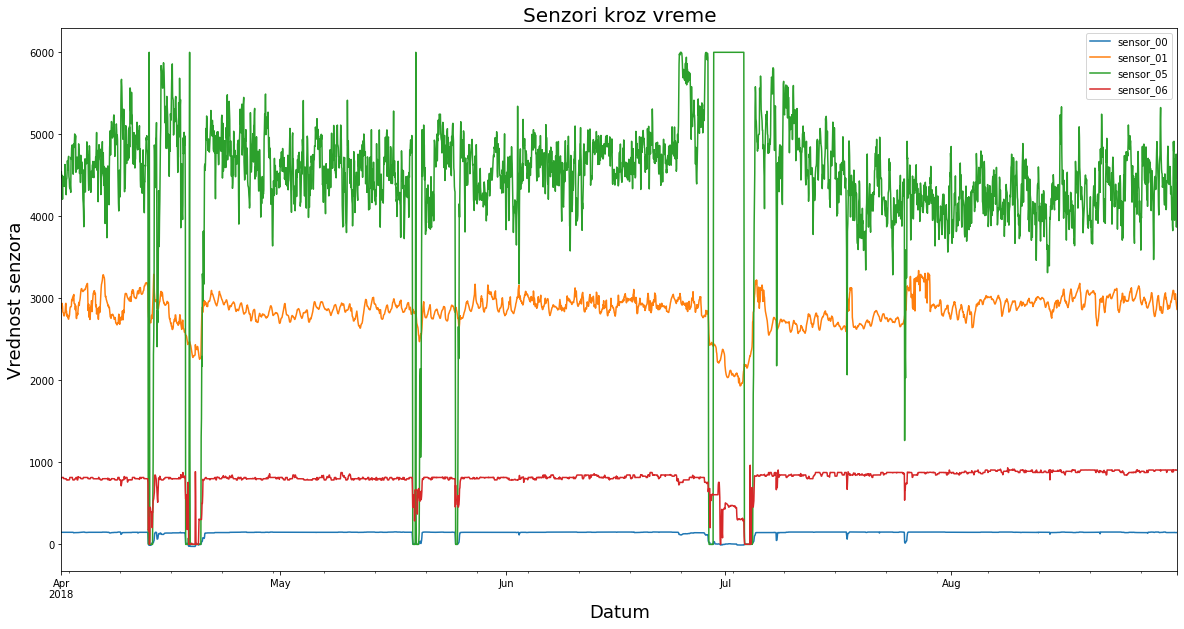

In [21]:
train_data[['sensor_00','sensor_01', 'sensor_05', 'sensor_06']].plot(figsize=(20,10))
plt.xlabel("Datum", fontsize=18)
plt.ylabel("Vrednost senzora", fontsize=18)
plt.title('Senzori kroz vreme', fontsize=20);

In [22]:
train_data_minute[train_data_minute['machine_status']=='BROKEN'].head(100)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,...,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,401.909700,324.652800,BROKEN
24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,...,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,177.662000,183.738400,BROKEN
69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,...,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,246.238400,257.523100,BROKEN
77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,...,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,220.196800,267.361100,BROKEN
128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,...,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,32.407406,169.719892,BROKEN
141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,...,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,192.129600,174.768500,BROKEN
166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,...,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,269.655985,205.729200,BROKEN


In [23]:
dates_broken = train_data_minute[train_data_minute['machine_status']=='BROKEN']['timestamp']

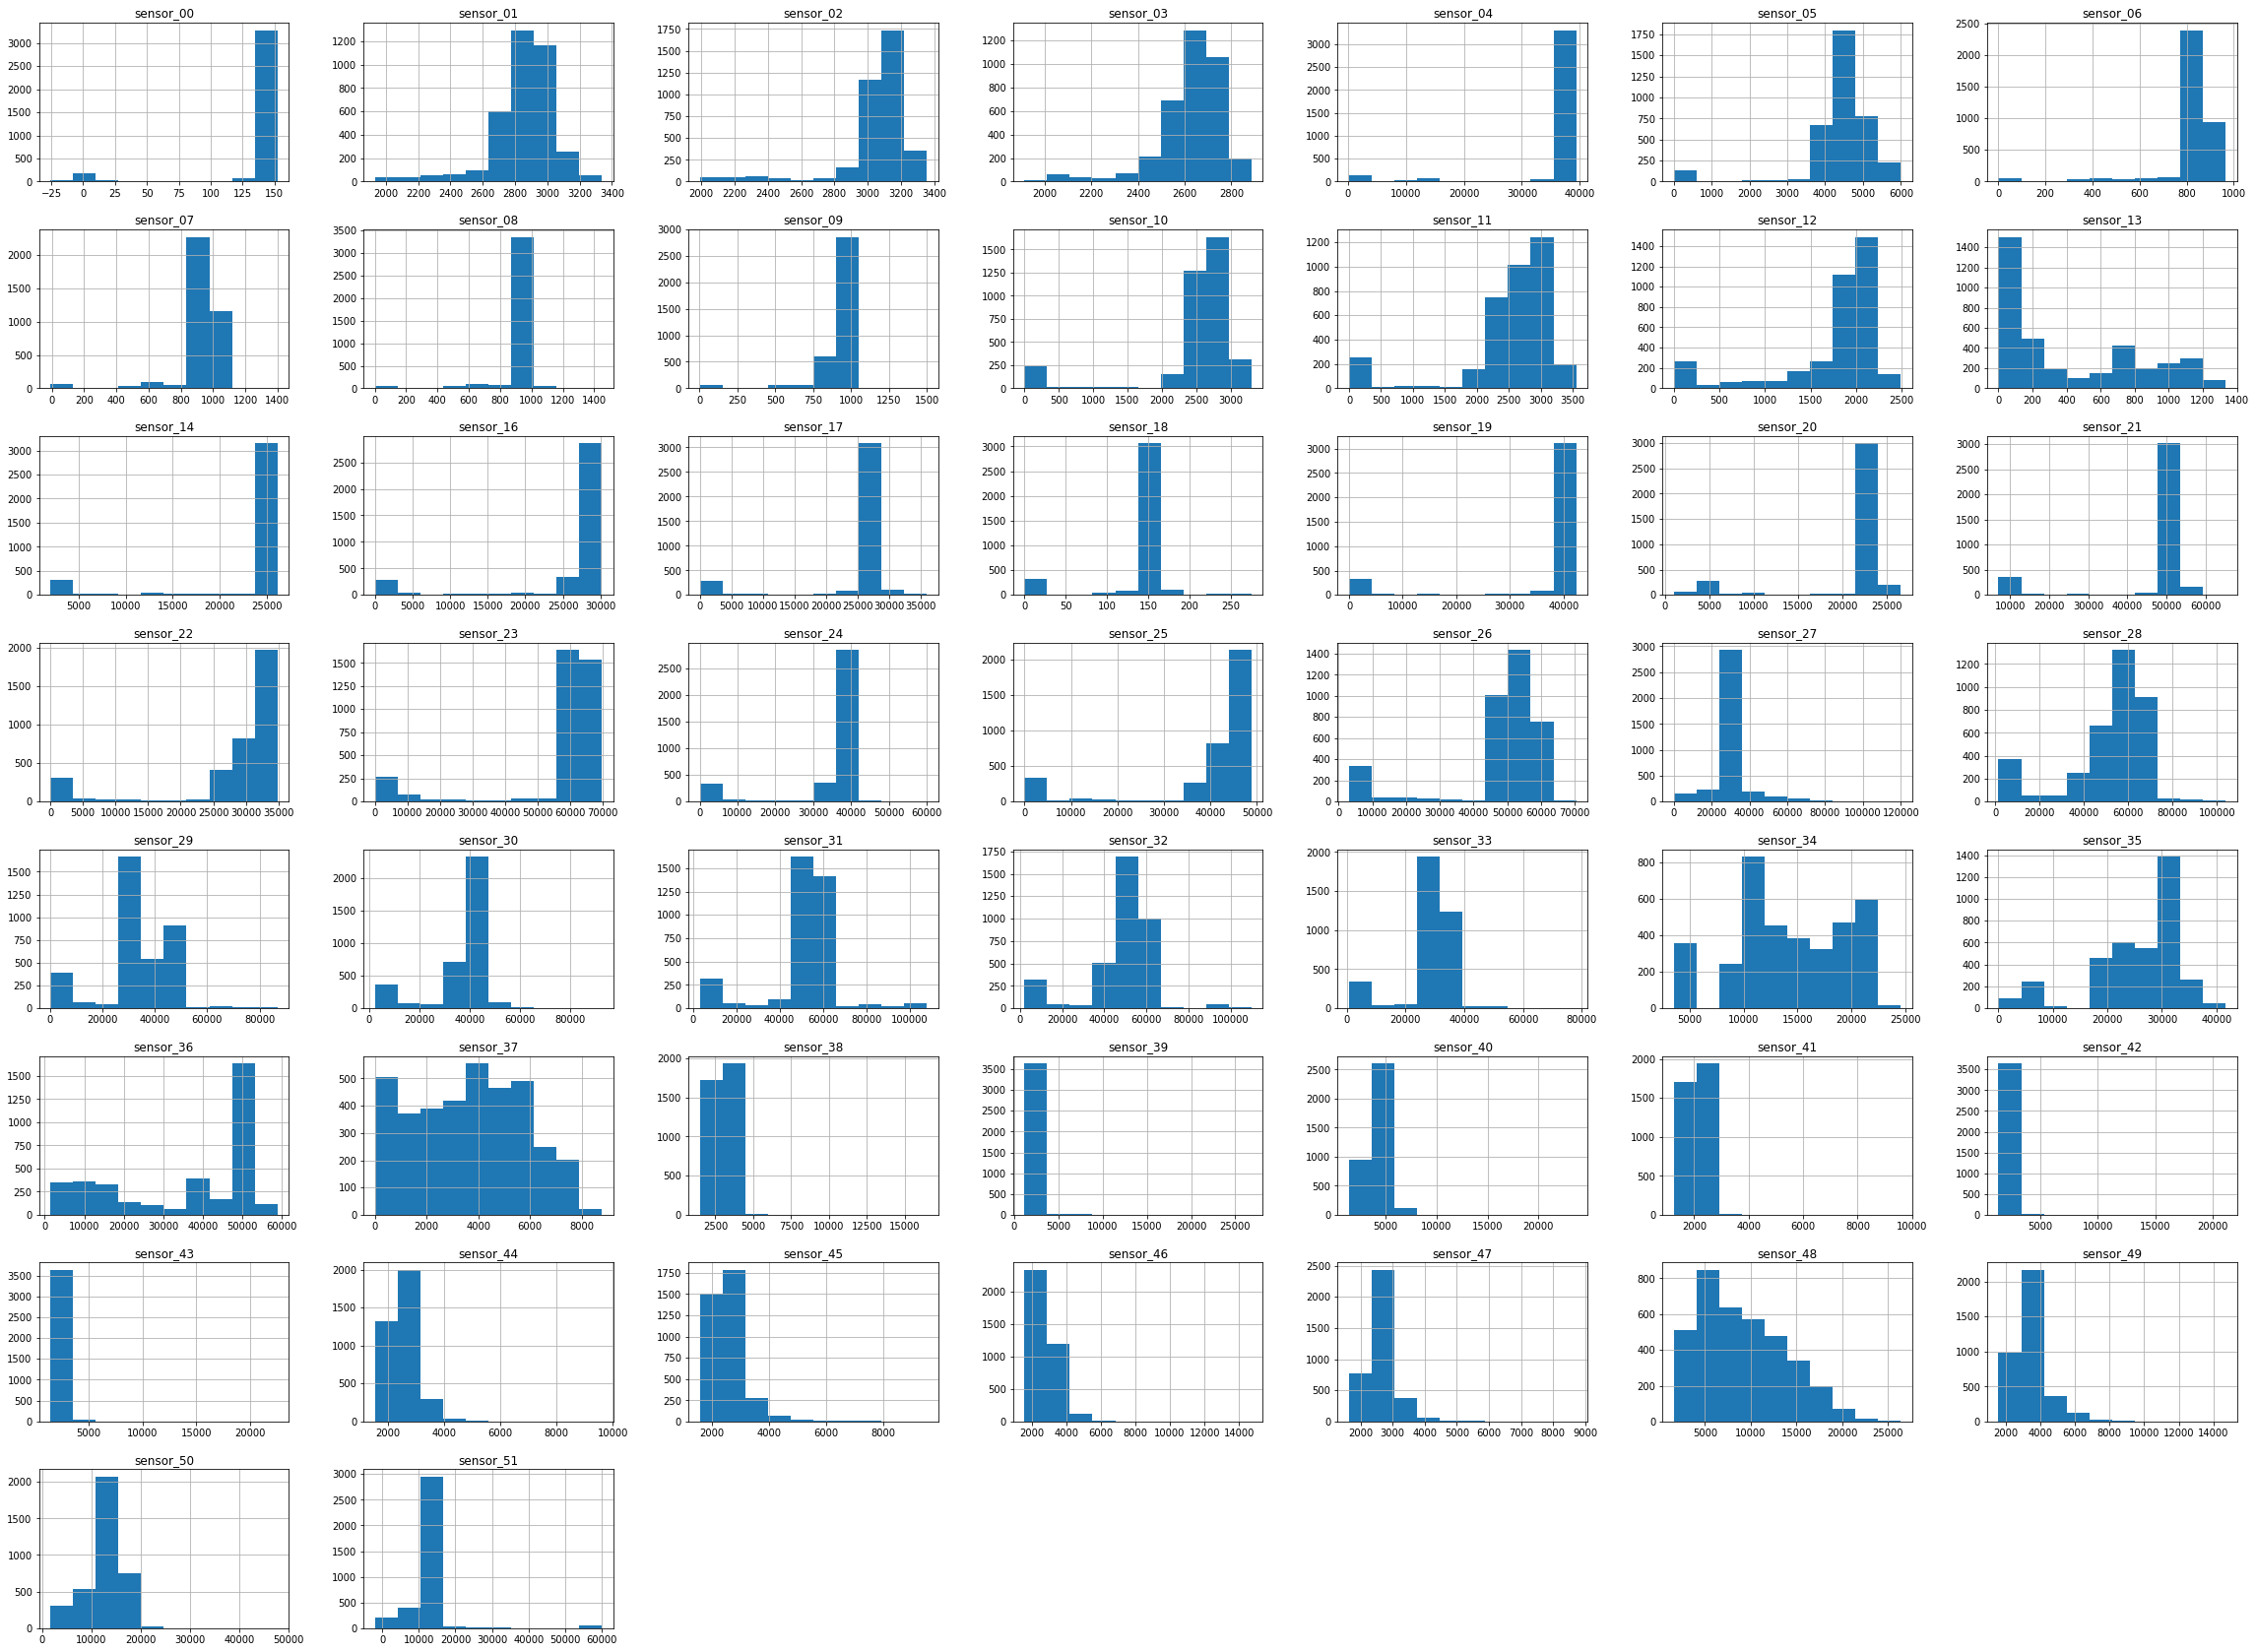

In [24]:
train_data.hist(column=train_data.columns, figsize=(40,30))
plt.show()

### Check the distribution

In [10]:
for column in train_data:
    # normality test
    stat, p = shapiro(train_data[column])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print(column+' looks Gaussian (fail to reject H0)')
    else:
        print(column+' does not look Gaussian (reject H0)')

Statistics=0.388, p=0.000
sensor_00 does not look Gaussian (reject H0)
Statistics=0.872, p=0.000
sensor_01 does not look Gaussian (reject H0)
Statistics=0.676, p=0.000
sensor_02 does not look Gaussian (reject H0)
Statistics=0.851, p=0.000
sensor_03 does not look Gaussian (reject H0)
Statistics=0.348, p=0.000
sensor_04 does not look Gaussian (reject H0)
Statistics=0.668, p=0.000
sensor_05 does not look Gaussian (reject H0)
Statistics=0.522, p=0.000
sensor_06 does not look Gaussian (reject H0)
Statistics=0.384, p=0.000
sensor_07 does not look Gaussian (reject H0)
Statistics=0.394, p=0.000
sensor_08 does not look Gaussian (reject H0)
Statistics=0.333, p=0.000
sensor_09 does not look Gaussian (reject H0)
Statistics=0.597, p=0.000
sensor_10 does not look Gaussian (reject H0)
Statistics=0.718, p=0.000
sensor_11 does not look Gaussian (reject H0)
Statistics=0.696, p=0.000
sensor_12 does not look Gaussian (reject H0)
Statistics=0.842, p=0.000
sensor_13 does not look Gaussian (reject H0)
Statis

### Apply BoxCox transformation

In [15]:
for column in train_data:
    if (train_data[column]>0).all():
        xt, _ = boxcox(train_data[column])
        stat, p = shapiro(xt)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        alpha = 0.05
        if p > alpha:
            print(column+' looks Gaussian (fail to reject H0)')
        else:
            print(column+' does not look Gaussian (reject H0)')
    else:
        print(column+' has negative values')


sensor_00 has negative values
Statistics=0.980, p=0.000
sensor_01 does not look Gaussian (reject H0)
Statistics=0.983, p=0.000
sensor_02 does not look Gaussian (reject H0)
Statistics=0.996, p=0.000
sensor_03 does not look Gaussian (reject H0)
Statistics=0.426, p=0.000
sensor_04 does not look Gaussian (reject H0)
sensor_05 has negative values
Statistics=0.849, p=0.000
sensor_06 does not look Gaussian (reject H0)
sensor_07 has negative values
Statistics=0.576, p=0.000
sensor_08 does not look Gaussian (reject H0)
Statistics=0.457, p=0.000
sensor_09 does not look Gaussian (reject H0)
sensor_10 has negative values
sensor_11 has negative values
sensor_12 has negative values
sensor_13 has negative values
Statistics=0.499, p=0.000
sensor_14 does not look Gaussian (reject H0)
sensor_16 has negative values
sensor_17 has negative values
sensor_18 has negative values
sensor_19 has negative values
Statistics=0.505, p=0.000
sensor_20 does not look Gaussian (reject H0)
Statistics=0.508, p=0.000
senso

### Apply Log transformation

In [25]:
for column in train_data:
    train_data[column] = np.log(train_data[column])
    stat, p = shapiro(train_data[column])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print(column+' looks Gaussian (fail to reject H0)')
    else:
        print(column+' does not look Gaussian (reject H0)')

Statistics=nan, p=1.000
sensor_00 looks Gaussian (fail to reject H0)
Statistics=0.821, p=0.000
sensor_01 does not look Gaussian (reject H0)
Statistics=0.620, p=0.000
sensor_02 does not look Gaussian (reject H0)
Statistics=0.811, p=0.000
sensor_03 does not look Gaussian (reject H0)
Statistics=0.256, p=0.000
sensor_04 does not look Gaussian (reject H0)
Statistics=nan, p=1.000
sensor_05 looks Gaussian (fail to reject H0)
Statistics=0.199, p=0.000
sensor_06 does not look Gaussian (reject H0)
Statistics=nan, p=1.000
sensor_07 looks Gaussian (fail to reject H0)
Statistics=0.155, p=0.000
sensor_08 does not look Gaussian (reject H0)
Statistics=0.132, p=0.000
sensor_09 does not look Gaussian (reject H0)
Statistics=nan, p=1.000
sensor_10 looks Gaussian (fail to reject H0)
Statistics=nan, p=1.000
sensor_11 looks Gaussian (fail to reject H0)
Statistics=nan, p=1.000
sensor_12 looks Gaussian (fail to reject H0)
Statistics=nan, p=1.000
sensor_13 looks Gaussian (fail to reject H0)
Statistics=0.396, p=

/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Data preparation

Here we can have scaling, normalizing of the data, train and test spit, etc.

### Modeling

- assume_centered - default=False, if True, the support of robust location and covariance estimates is computed, and a covariance estimate is recomputed from it, without centering the data. Useful to work with data whose mean is significantly equal to zero but is not exactly zero.

- support_fraction - default=None, the proportion of points to be included in the support of the raw MCD estimate. If None, the minimum value of support_fraction will be used within the algorithm: [n_sample + n_features + 1] / 2. Range is (0, 1).

- contamination - default=0.1, the amount of contamination of the data set, i.e. the proportion of outliers in the data set. Range is (0, 0.5).

In [22]:
# initialize the model
elpenv = EllipticEnvelope(contamination=0.025, 
                          random_state=1)

### Prediction

In [23]:
# identify anomalies in the training dataset
pred = elpenv.fit_predict(train_data)

In [25]:
train_data['is_anomaly'] = pred

### Evaluation

In [26]:
train_data['is_anomaly'].value_counts()

 1    3580
-1      92
Name: is_anomaly, dtype: int64

In [27]:
train_data[train_data['is_anomaly']==-1]['is_anomaly'].head(20)

timestamp
2018-05-01 09:00:00   -1
2018-05-01 10:00:00   -1
2018-05-01 11:00:00   -1
2018-05-01 12:00:00   -1
2018-05-01 13:00:00   -1
2018-05-01 14:00:00   -1
2018-05-02 10:00:00   -1
2018-05-02 11:00:00   -1
2018-05-02 12:00:00   -1
2018-05-02 13:00:00   -1
2018-05-02 14:00:00   -1
2018-05-02 15:00:00   -1
2018-05-03 00:00:00   -1
2018-05-03 05:00:00   -1
2018-05-03 06:00:00   -1
2018-05-03 07:00:00   -1
2018-05-03 08:00:00   -1
2018-05-03 09:00:00   -1
2018-05-03 10:00:00   -1
2018-05-03 11:00:00   -1
Name: is_anomaly, dtype: int64

In [29]:
dates_broken

17155    2018-04-12 21:55:00
24510    2018-04-18 00:30:00
69318    2018-05-19 03:18:00
77790    2018-05-25 00:30:00
128040   2018-06-28 22:00:00
141131   2018-07-08 00:11:00
166440   2018-07-25 14:00:00
Name: timestamp, dtype: datetime64[ns]